In [1]:
# This Code will backtest a Time Series Momentum strategy, and highlight the utility of it when combined with traditional Beta (S&P500)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pyfolio as pf
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import pyfolio as pf
from scipy.stats import skew
import yfinance as yfin
pd.set_option('display.max_rows', 20) 
pd.set_option('display.max_columns', 15)

c:\Users\mnk\anaconda3\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Organising and Cleaning

In [3]:
formation = dt.datetime(1991,12,31)
formation_dates = []
for i in range(0,372):
    formation_dates.append(formation + MonthEnd(i))
returns_dates = []
for i in range(1,373):
    returns_dates.append(formation + MonthEnd(i))

In [4]:
data = pd.read_excel('/Users/mnk/Downloads/Trend Following Investment Universe.xlsx',index_col=0)
data.index = pd.to_datetime(data.index,yearfirst=True)
data = data.pct_change()
returns_combined_rolled_futures = data
returns_combined_rolled_futures.replace({0:np.nan},inplace=True)

In [5]:
returns_combined_rolled_futures

,CT1 Comdty,C 1 Comdty,LB1 Comdty,LC1 Comdty,LH1 Comdty,O 1 Comdty,RR1 Comdty,...,L 1 Comdty,IK1 Comdty,OE1 Comdty,FV1 Comdty,US1 Comdty,CN1 Comdty,FF1 Comdty
Dates,,,,,,,,,,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-02,-0.010569,-0.008342,-0.005793,0.000969,-0.001538,-0.014658,0.021534,...,NaN,NaN,NaN,-0.000777,-0.002534,-0.001663,0.003171
1990-01-03,0.011121,0.003155,-0.001059,-0.003873,0.004620,0.011570,-0.002635,...,NaN,NaN,NaN,-0.002021,-0.004128,-0.006143,0.000218
1990-01-04,-0.025326,-0.001048,0.015376,-0.002592,0.032192,-0.014706,0.007926,...,NaN,NaN,NaN,0.000312,0.000638,-0.000315,0.000218
1990-01-05,-0.015442,-0.002099,0.012533,-0.000975,0.010891,0.006633,0.009174,...,NaN,NaN,NaN,-0.000156,-0.002549,-0.002096,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-23,0.014355,0.020900,NaN,0.000280,-0.012881,0.007365,-0.003228,...,NaN,0.011487,0.006076,0.004516,0.015844,0.015505,NaN
2023-08-24,-0.001392,-0.008399,NaN,0.011473,0.024507,0.048369,0.017811,...,NaN,-0.001214,-0.000259,-0.002064,-0.003119,-0.006576,0.000026
2023-08-25,0.016494,-0.003176,NaN,0.002490,-0.008077,0.026288,-0.002227,...,NaN,-0.003559,-0.002761,-0.001182,-0.000782,-0.004503,-0.000026


In [6]:
returns_combined_rolled_futures.drop(['AD1 Curncy'],axis=1,inplace=True)
returns_combined_rolled_futures.drop(['BP1 Curncy'],axis=1,inplace=True)
returns_combined_rolled_futures.drop(['ES1 Comdty'],axis=1,inplace=True)

In [7]:
# Calculating Monthly Returns
def calculate_yearly_return(group):
    non_nan_values = group.dropna()
    if len(non_nan_values) == 0:
        return np.nan
    return (non_nan_values + 1).prod() - 1


monthly_returns = returns_combined_rolled_futures.resample('M').apply(calculate_yearly_return)

In [8]:
past_1 = (monthly_returns+1).rolling(1).apply(np.prod)-1
past_3 = (monthly_returns+1).rolling(3).apply(np.prod)-1
past_12 = (monthly_returns+1).rolling(12).apply(np.prod)-1

In [9]:
# Cleaning and organising
filler = pd.DataFrame(data=range(len(formation_dates)),index=formation_dates)
returns_combined_rolled_futures = returns_combined_rolled_futures.merge(filler,left_index=True,right_index=True,how='outer')
returns_combined_rolled_futures.drop([returns_combined_rolled_futures.columns[67]],axis=1,inplace=True)
returns_combined_rolled_futures[returns_combined_rolled_futures.isna().all(axis=1)] = returns_combined_rolled_futures[returns_combined_rolled_futures.isna().all(axis=1)].fillna(0)

In [10]:
# rolling backward looking volatility estimate
past_std = returns_combined_rolled_futures.rolling(120,min_periods=80).std()*(252**0.5)

# Backtesting

<function matplotlib.pyplot.show(close=None, block=None)>

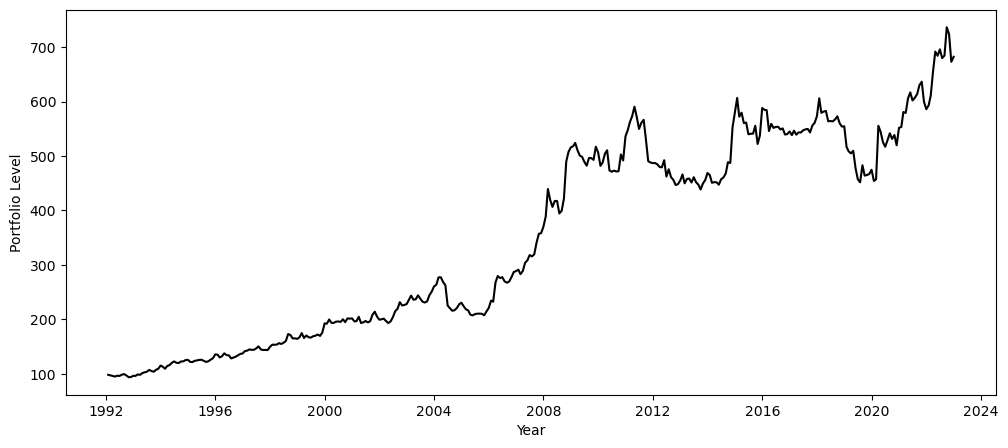

In [11]:
def Trend_Following(formation):
    end_measurement = formation
    slow_lookback = past_12.loc[end_measurement]
    medium_looback = past_3.loc[end_measurement]
    fast_lookback = past_1.loc[end_measurement]
    merged = pd.concat([slow_lookback,medium_looback,fast_lookback],axis=1)
    merged = merged[(merged != 0).all(axis=1)]
    merged.dropna(inplace=True)
    merged[merged > 0.001] = 1
    merged[merged < -0.001] = -1
    merged['position'] = merged.sum(axis=1)
    vol_lookback = past_std.loc[end_measurement]
    vol_lookback.dropna(inplace=True)
    returns = monthly_returns.loc[end_measurement + MonthEnd(1),monthly_returns.columns.isin(merged.index)]
    wppp = pd.concat([returns,merged['position'],vol_lookback],axis=1)
    wppp = wppp[(wppp != 0).all(axis=1)]
    wppp.dropna(inplace=True)
    wppp['weighting'] = (1/wppp.iloc[:,2])/(sum(1/wppp.iloc[:,2])) * wppp.iloc[:,1]
    months_profit = sum(wppp.iloc[:,0] * wppp.iloc[:,3])
    momentum_profit = months_profit * (0.30/sum(wppp.iloc[:,3].abs() * (wppp.iloc[:,2])))
    wppp['Pounds'] = wppp['weighting']/sum(wppp['weighting'])*1000000
    return momentum_profit
Trend_Following_Returns = []
for i in formation_dates:
    Trend_Following_Returns.append(Trend_Following(i))
Trend_Following_Returns = pd.DataFrame(data=Trend_Following_Returns,index=returns_dates)
equity_curve = 100*(1+Trend_Following_Returns).cumprod() 
fig = plt.figure(figsize=(12,5))
plt.plot(equity_curve.index,equity_curve,color='k')
plt.xlabel('Year')
plt.ylabel('Portfolio Level')
plt.show

In [12]:
Annual_Return = Trend_Following_Returns[:].mean()*12
Annual_Return

0    0.069145
dtype: float64

In [13]:
std = Trend_Following_Returns.std()*(12**0.5)
std

0    0.120307
dtype: float64

In [14]:
skew(Trend_Following_Returns)

array([1.03509657])

In [15]:
sharpe = Annual_Return/std
sharpe

0    0.574734
dtype: float64

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

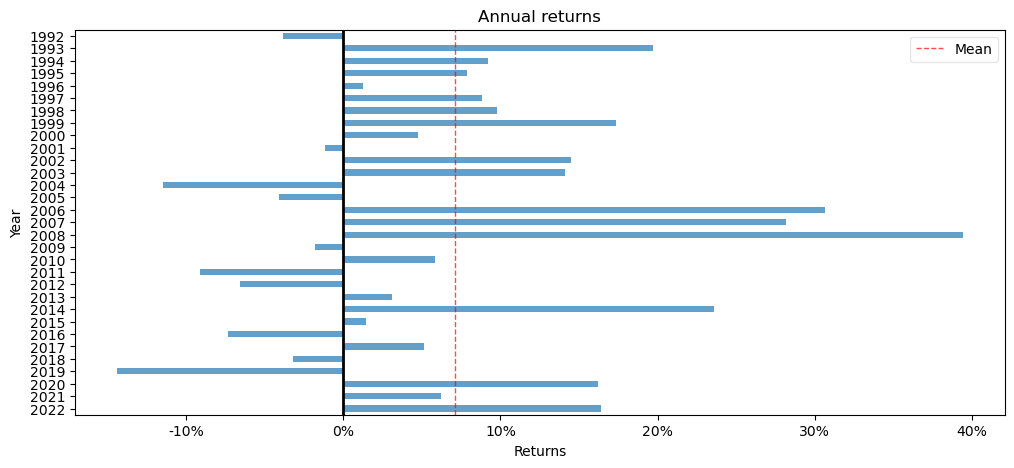

In [16]:
fig = plt.figure(figsize=(12,5))
pf.plot_annual_returns(Trend_Following_Returns)

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

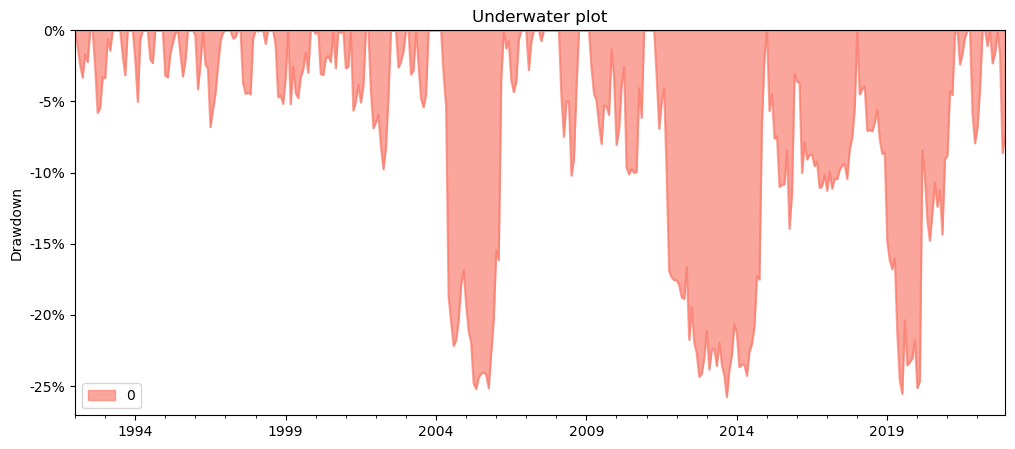

In [17]:
fig = plt.figure(figsize=(12,5))
pf.plot_drawdown_underwater(Trend_Following_Returns)

# Getting SP500 Data

In [18]:
SP500 = yfin.download('spy',start='1992-01-01',end='2022-12-31')['Close']
SP500 = SP500.pct_change()
SP500_monthly = (SP500).resample('M').agg(lambda x: (x+1).prod()-1)
SP500_monthly

[*********************100%***********************]  1 of 1 completed


Date
1993-01-31    0.000000
1993-02-28    0.010669
1993-03-31    0.017593
1993-04-30   -0.025588
1993-05-31    0.026969
                ...   
2022-08-31   -0.040802
2022-09-30   -0.096159
2022-10-31    0.081276
2022-11-30    0.055592
2022-12-31   -0.061936
Freq: M, Name: Close, Length: 360, dtype: float64

In [19]:
Combined = pd.concat([Trend_Following_Returns[12:],SP500_monthly],axis=1)
Combined.columns = ['Trend Following','SP500']

In [20]:
Combined

,Trend Following,SP500
1993-01-31,-0.000912,0.000000
1993-02-28,0.028557,0.010669
1993-03-31,-0.008360,0.017593
1993-04-30,0.031856,-0.025588
1993-05-31,0.014920,0.026969
...,...,...
2022-08-31,0.006944,-0.040802
2022-09-30,0.076022,-0.096159
2022-10-31,-0.017182,0.081276
2022-11-30,-0.070283,0.055592


In [21]:
# Correlation of the 2 strategies. We can see the Trend Following strategy is very defensive
Combined.corr().iloc[0,1]

-0.22807911921415797

In [22]:
# 50/50 Allocation to both
Combined_Portfolio = Combined.sum(axis=1)/2

In [23]:
Annual_Return = Combined_Portfolio.mean()*12
Annual_Return

0.07819929134120078

In [24]:
std = Combined_Portfolio.std()*(12**0.5)
std

0.08511894380338787

In [25]:
sharpe = Annual_Return/std
sharpe

0.9187060817134848

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

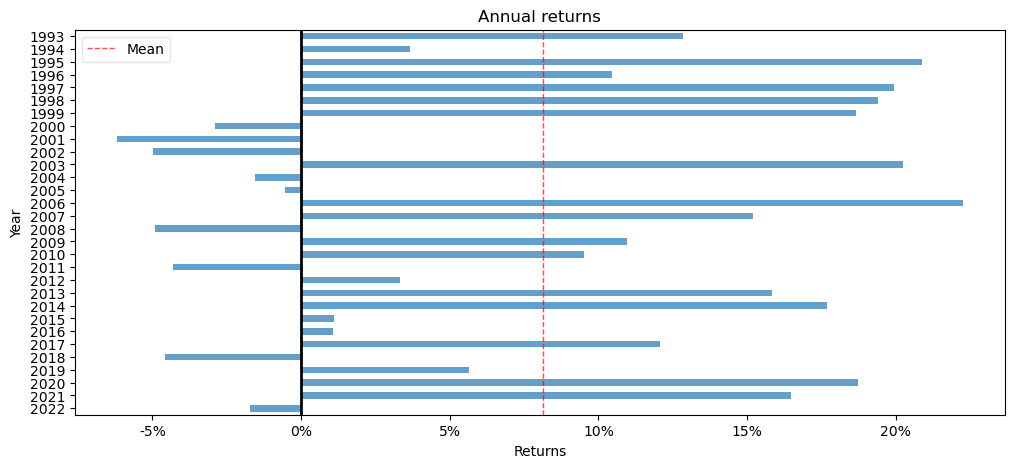

In [26]:
fig = plt.figure(figsize=(12,5))
pf.plot_annual_returns(Combined_Portfolio)

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

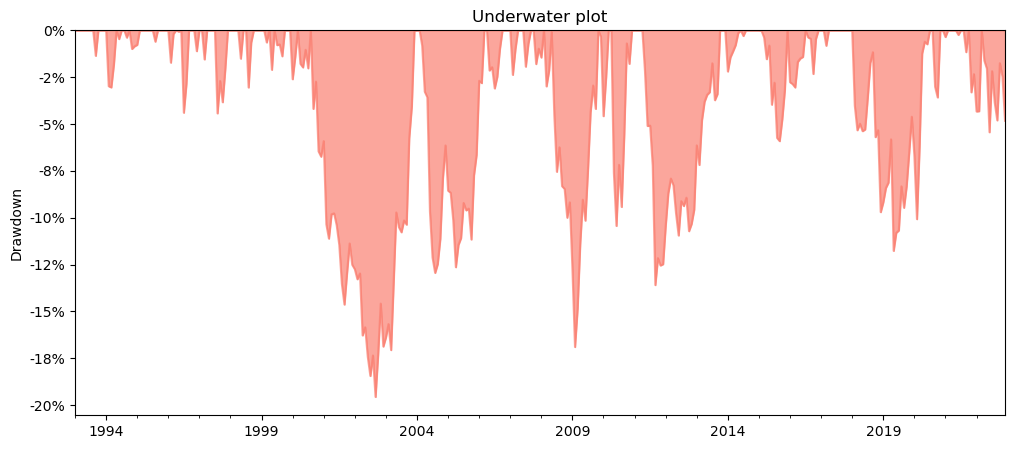

In [27]:
fig = plt.figure(figsize=(12,5))
pf.plot_drawdown_underwater(Combined_Portfolio)

<function matplotlib.pyplot.show(close=None, block=None)>

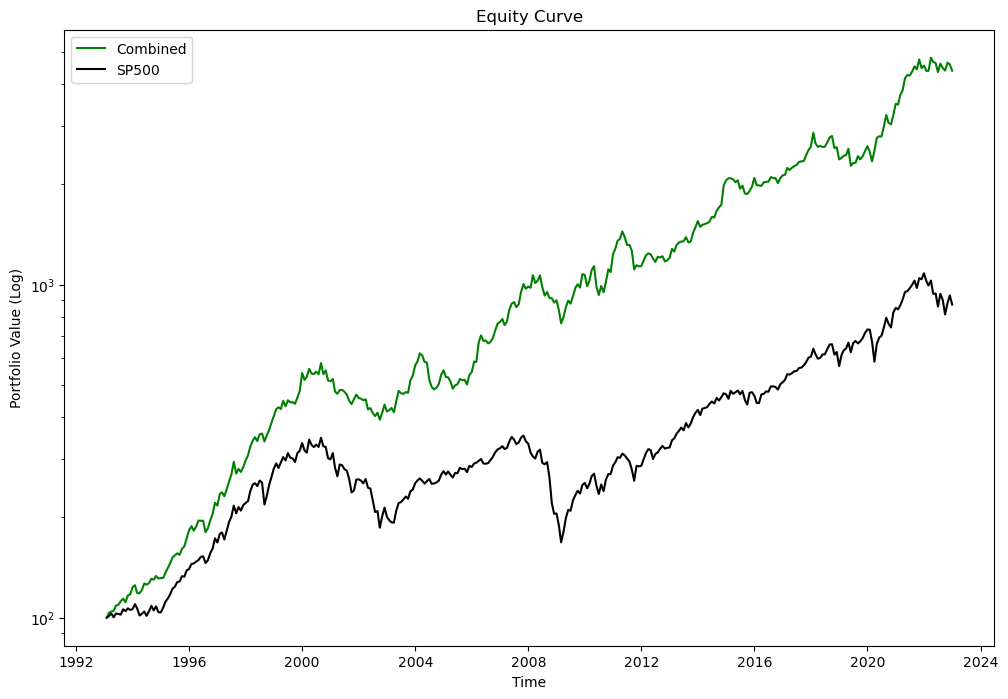

In [28]:
# Combined Strategy is levered up to the same volatility as the S&P500
Leverage = (SP500_monthly.std()*(12**0.5))/(Combined_Portfolio.std()*(12**0.5))
fig = plt.figure(figsize=(12,8))
plt.plot(Combined_Portfolio.index,(100*((Combined_Portfolio*Leverage)+1).cumprod()),label='Combined',color='g')
plt.plot(SP500_monthly.index,100*(SP500_monthly+1).cumprod(),label='SP500',color='k')
plt.legend()
plt.yscale('log')
plt.ylabel('Portfolio Value (Log)')
plt.xlabel('Time')
plt.title('Equity Curve')
plt.show

# Insight

In [29]:
formation = dt.datetime(2006,1,31)
end_measurement = formation
slow_lookback = past_12.loc[end_measurement]
medium_looback = past_3.loc[end_measurement]
fast_lookback = past_1.loc[end_measurement]
merged = pd.concat([slow_lookback,medium_looback,fast_lookback],axis=1)
merged = merged[(merged != 0).all(axis=1)]
merged.dropna(inplace=True)
merged[merged > 0.0001] = 1
merged[merged < 0.0001] = -1
merged['position'] = merged.sum(axis=1)
vol_lookback = past_std.loc[end_measurement]
vol_lookback.dropna(inplace=True)
returns = monthly_returns.loc[end_measurement + MonthEnd(1),monthly_returns.columns.isin(merged.index)]
wppp = pd.concat([returns,merged['position'],vol_lookback],axis=1)
wppp = wppp[(wppp != 0).all(axis=1)]
wppp.dropna(inplace=True)
wppp['weighting'] = (1/wppp.iloc[:,2])/(sum(1/wppp.iloc[:,2])) * wppp.iloc[:,1]
months_profit = sum(wppp.iloc[:,0] * wppp.iloc[:,3])
momentum_profit = months_profit * (0.30/sum(wppp.iloc[:,3].abs() * (wppp.iloc[:,2])))
wppp['Pounds'] = ((wppp['weighting']/sum(wppp['weighting'])*1000000).abs()) * (0.30/sum(wppp.iloc[:,3].abs() * (wppp.iloc[:,2])))
wppp.columns = ['1 Month Forward Return','Signal','Ex Ante Vol Estimate','Weight','Notional Exposure £']
wppp['Notional Exposure £'] = wppp['Notional Exposure £'].apply(lambda x: '{:.2f}'.format(x))

In [30]:
wppp

,1 Month Forward Return,Signal,Ex Ante Vol Estimate,Weight,Notional Exposure £
CT1 Comdty,-0.005025,3.0,0.285531,0.012340,47139.10
C 1 Comdty,0.042286,3.0,0.262244,0.013436,51324.91
LB1 Comdty,-0.071107,-1.0,0.412748,-0.002846,10869.97
LC1 Comdty,-0.067611,1.0,0.133047,0.008828,33721.71
LH1 Comdty,0.098749,-3.0,0.247293,-0.014248,54427.99
...,...,...,...,...,...
ER1 Comdty,0.000051,-1.0,0.004742,-0.247680,946133.91
OE1 Comdty,-0.000802,-3.0,0.026297,-0.133989,511834.60
FV1 Comdty,-0.004729,-3.0,0.027640,-0.127476,486954.89
US1 Comdty,0.002215,-1.0,0.068382,-0.017175,65610.00
